In [136]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, Conv1D, GRU, Bidirectional,MaxPooling1D
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [137]:
#  Load and preprocess data

data_path = 'data_modified/LG_modified.csv'  # update path
data = pd.read_csv(data_path)

#label encoder
label_encoder_Fault = LabelEncoder()
data['Fault'] = label_encoder_Fault.fit_transform(data['Fault'])
y_full = data['Fault'].values
X_raw = data[['Absolute Ia', 'Absolute Ib', 'Absolute Ic']].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

data.head()

,Time,Absolute Ia,Absolute Ib,Absolute Ic,Fault
0,0.000000,0.049527,0.190896,0.130947,0
1,0.000167,0.055313,0.187909,0.123746,0
2,0.000333,0.060952,0.184199,0.116002,0
3,0.000500,0.066418,0.179768,0.107739,0
4,0.000667,0.071680,0.174620,0.098983,0


In [138]:
# Windowing function
def create_windows(X_array, y_array, window_size=90, step=5):
    X_windows, y_windows = [], []
    for i in range(0, len(X_array) - window_size + 1, step):
        X_windows.append(X_array[i:i+window_size, :])
        y_windows.append(y_array[i+window_size-1])
    return np.array(X_windows), np.array(y_windows)

X_windowed, y_windowed = create_windows(X_scaled, y_full, window_size=90, step=5)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [139]:
# Simple Attention Layer
class SimpleAttention(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.dense = Dense(1)

    def call(self, inputs):
        score = self.dense(inputs)                  # [batch, seq_len, 1]
        weights = tf.nn.softmax(score, axis=1)      # attention weights
        return tf.reduce_sum(inputs * weights, axis=1)  # context vector


In [140]:
# Build model
def build_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv1D(128, 5, padding='same', activation='relu')(inp)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = SimpleAttention()(x)

    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    return model

num_classes = 2
model = build_model(X_train.shape[1:], num_classes)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 90, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 90, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 45, 128)        │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention_12             │ (None, 128)            │           129 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,059 (332.26 KB)

 Trainable params: 85,059 (332.26 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Training with history tracking
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9049 - loss: 0.3753 - val_accuracy: 0.9068 - val_loss: 0.3472
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9641 - loss: 0.1683 - val_accuracy: 0.9322 - val_loss: 0.2773
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9662 - loss: 0.1391 - val_accuracy: 0.9322 - val_loss: 0.2345
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9672 - loss: 0.1198 - val_accuracy: 0.9322 - val_loss: 0.1905
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9715 - loss: 0.0990 - val_accuracy: 0.9322 - val_loss: 0.1943
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9757 - loss: 0.0937 - val_accuracy: 0.9576 - val_loss: 0.1716
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9778 - loss: 0.0867 - val_accuracy: 0.9661 - val_loss: 0.1293
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9767 - loss: 0.0822 - val_accuracy: 0.9661 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


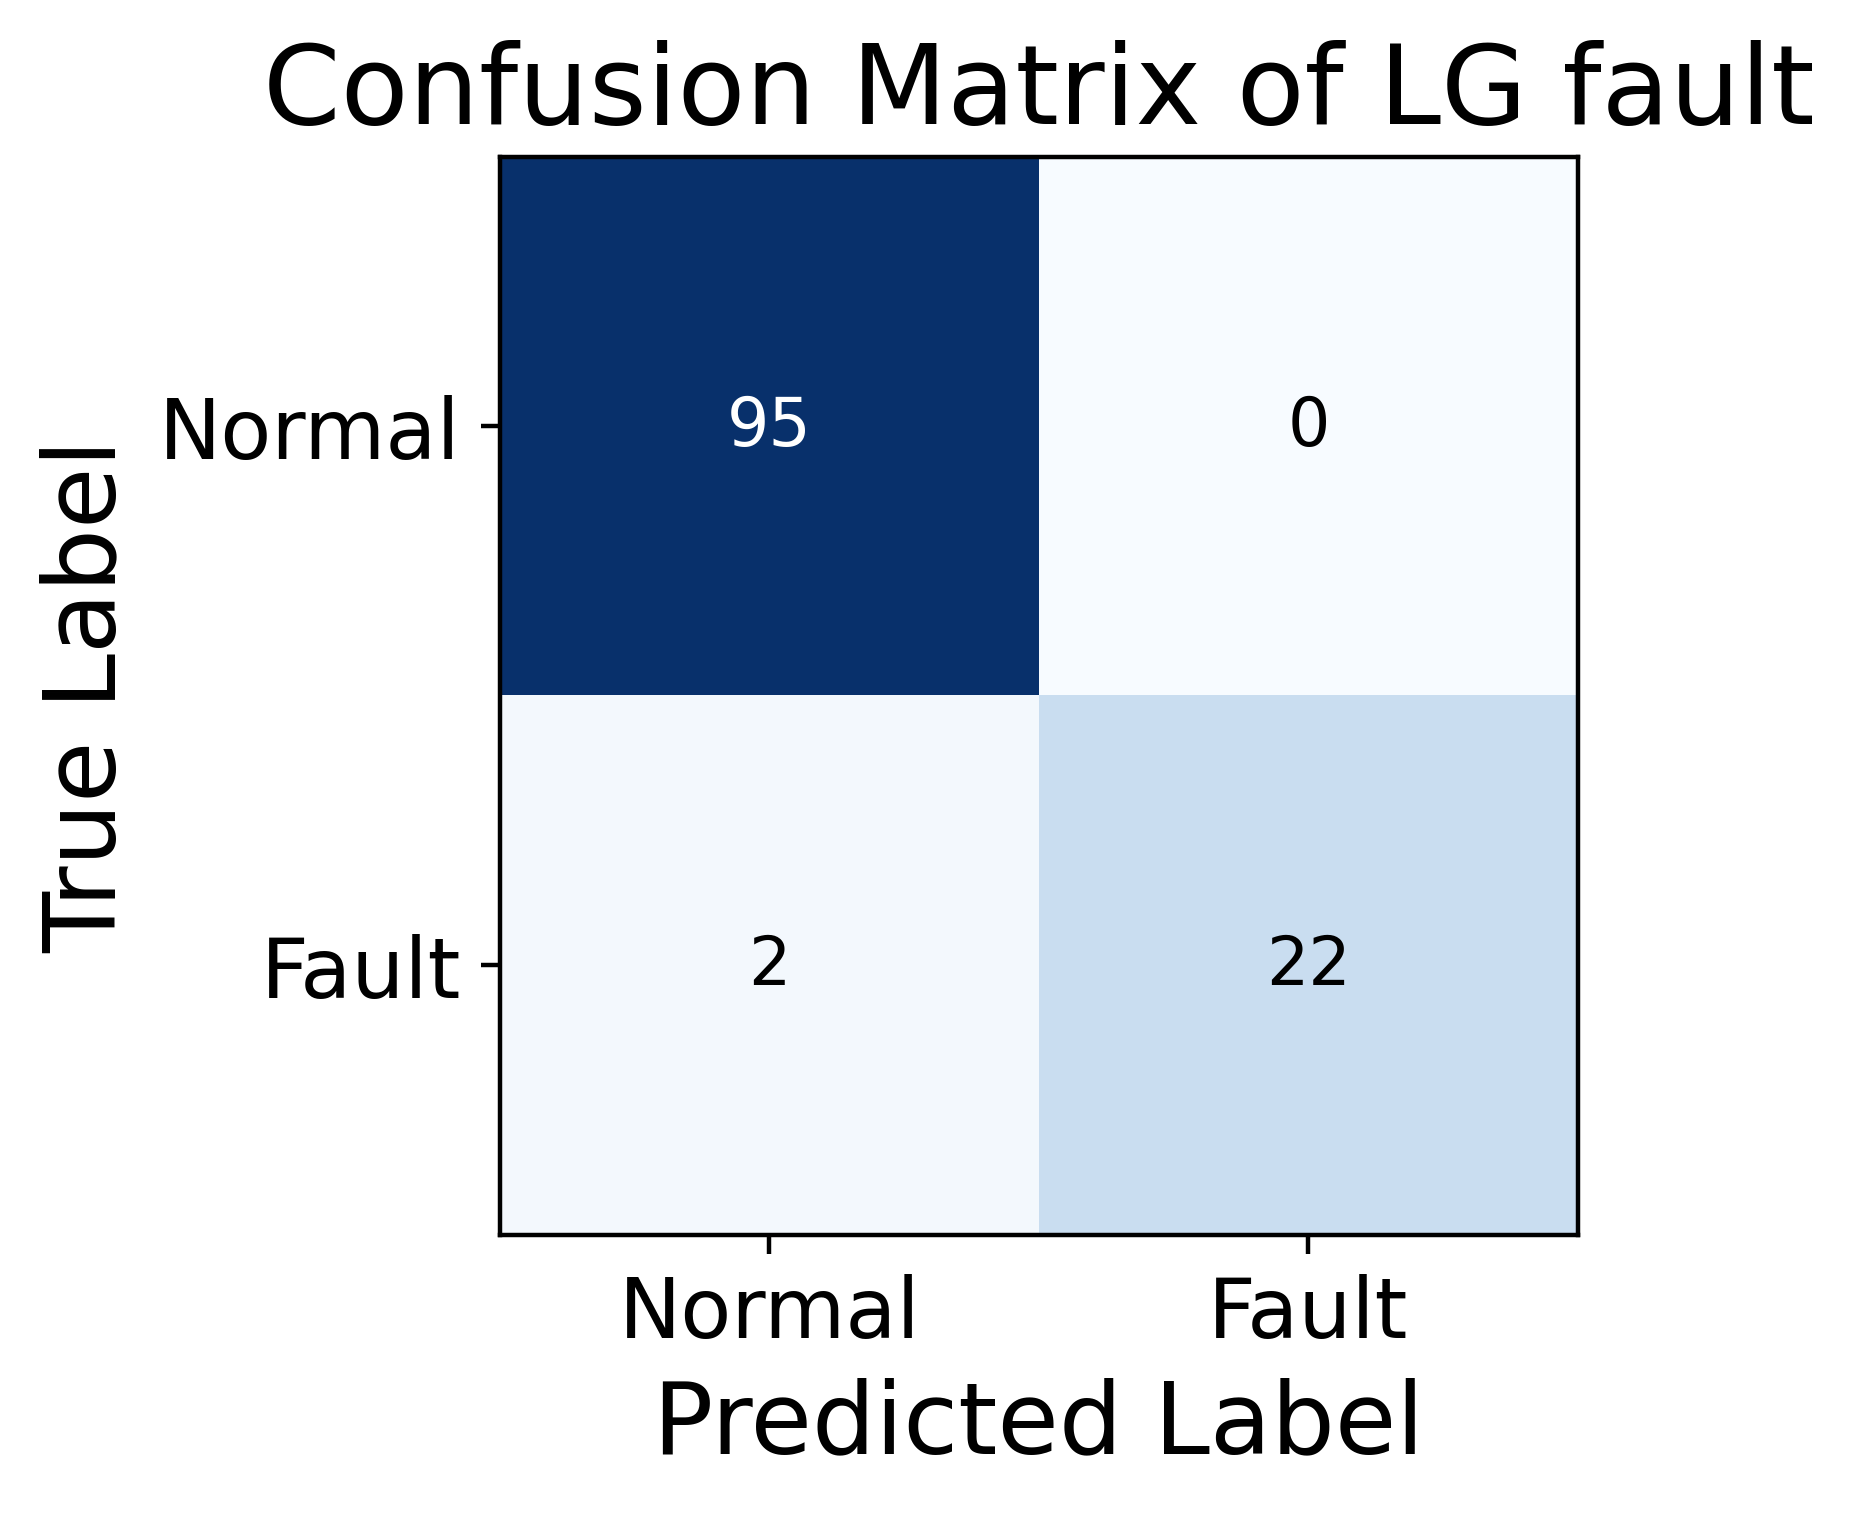

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import font_manager as fm

# ---- Confusion Matrix ----
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9, 3.5), dpi=400)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
thresh = cm.max() / 2.0
for i in range (cm.shape[0]):
  for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j],
         ha='center', va='center',
         color="white" if cm[i, j] > thresh else "black",
         fontsize=12)
plt.title('Confusion Matrix of LG fault',fontsize = 20)

plt.xlabel('Predicted Label',fontsize = 18)
plt.ylabel('True Label',fontsize = 18)
plt.xticks([0, 1], ['Normal', 'Fault'],fontsize = 15)
plt.yticks([0, 1], ['Normal', 'Fault'],fontsize = 15)
plt.show()

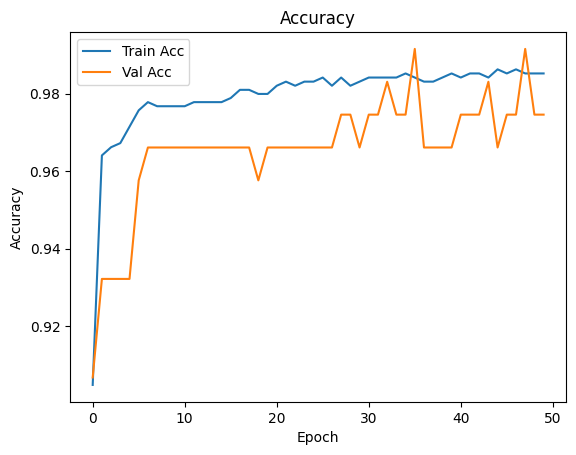

In [143]:
# Accuracy
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



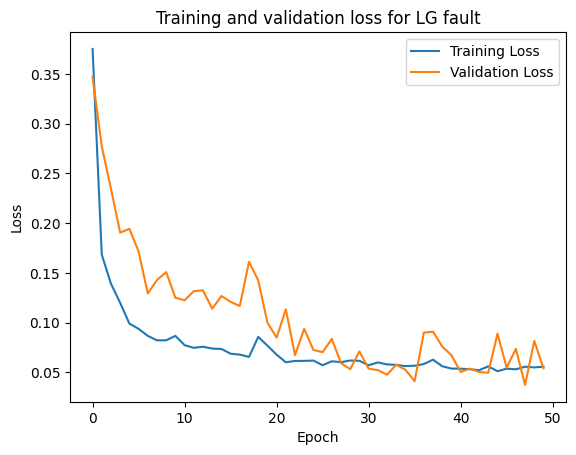

In [144]:
# Loss
plt.subplot(1,1,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss for LG fault')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [145]:
# Format as percent
def to_percent(val):
    return f"{val * 100:.2f}%"

# Create accuracy and loss tables from history and test results
accuracy_table = pd.DataFrame({
    "Train Accuracy": [history.history['accuracy'][-1]],
    "Validation Accuracy": [history.history['val_accuracy'][-1]],
    "Test Accuracy": [test_acc]
})

loss_table = pd.DataFrame({
    "Train Loss": [history.history['loss'][-1]],
    "Validation Loss": [history.history['val_loss'][-1]],
    "Test Loss": [test_loss]
})

accuracy_table_percent = accuracy_table.copy()
accuracy_table_percent["Train Accuracy"] = accuracy_table_percent["Train Accuracy"].apply(to_percent)
accuracy_table_percent["Validation Accuracy"] = accuracy_table_percent["Validation Accuracy"].apply(to_percent)
accuracy_table_percent["Test Accuracy"] = accuracy_table_percent["Test Accuracy"].apply(to_percent)
display(accuracy_table_percent)

loss_table_percent = loss_table.copy()
loss_table_percent["Train Loss"] = loss_table_percent["Train Loss"]
loss_table_percent["Validation Loss"] = loss_table_percent["Validation Loss"]
loss_table_percent["Test Loss"] = loss_table_percent["Test Loss"]
display(loss_table_percent)


,Train Accuracy,Validation Accuracy,Test Accuracy
0,98.52%,97.46%,98.32%


,Train Loss,Validation Loss,Test Loss
0,0.055658,0.053986,0.063471
